# Servomotor Analysis, Pressure

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm
plt.style.use("ggplot")
from ipywidgets.widgets import interact, Layout

In [2]:
df_servo_open = pd.read_csv("TilSK/servoindikeringOPEN.csv",";", skiprows=(3))

df_servo_close = pd.read_csv("TilSK/servoindikeringCLOSE.csv",";", skiprows=(3))

df_servo_v1 = pd.DataFrame()
df_servo_v1 = df_servo_open[['Relative Time (ms)', 'POS;WG_PILOT', 'HWI;WG_SIGNAL', 
                             'HWI;Servo_pressure +', 'HWI;Servo_pressure -']]
df_servo_v1 = df_servo_v1.rename(columns={'Relative Time (ms)': 'Relative Time', 
                                          'POS;WG_PILOT': 'pos', 
                                          'HWI;WG_SIGNAL': 'FCA', 
                                          'HWI;Servo_pressure +': 'HWI;Servo_pressure +', 
                                          'HWI;Servo_pressure -': 'HWI;Servo_pressure -'})
df_servo_v1 = df_servo_v1.set_index('Relative Time')
df_servo_v1 = df_servo_v1.iloc[1:] 

df_servo_v1 = df_servo_v1.apply(lambda x: x.str.replace(',','.'))





df_servo_v2 = pd.DataFrame()
df_servo_v2 = df_servo_close[['Relative Time (ms)', 'POS;WG_PILOT', 'HWI;WG_SIGNAL', 
                              'HWI;Servo_pressure +', 'HWI;Servo_pressure -']]
df_servo_v2 = df_servo_v2.rename(columns={'Relative Time (ms)': 'Relative Time', 
                                          'POS;WG_PILOT': 'pos', 
                                          'HWI;WG_SIGNAL': 'FCA', 
                                          'HWI;Servo_pressure +': 'HWI;Servo_pressure +', 
                                          'HWI;Servo_pressure -': 'HWI;Servo_pressure -'})
df_servo_v2 = df_servo_v2.set_index('Relative Time')
df_servo_v2 = df_servo_v2.iloc[1:] 

df_servo_v2 = df_servo_v2.apply(lambda x: x.str.replace(',','.'))

df_servo_v3 = pd.concat([df_servo_v1, df_servo_v2])


df_servo_v3 = df_servo_v3.reset_index(inplace=False)

cols = df_servo_v3.columns

for col in cols:
    df_servo_v3[col] = df_servo_v3[col].astype(float)
    
df_servo_v3["diff"] = df_servo_v3['HWI;Servo_pressure +'] - df_servo_v3['HWI;Servo_pressure -']


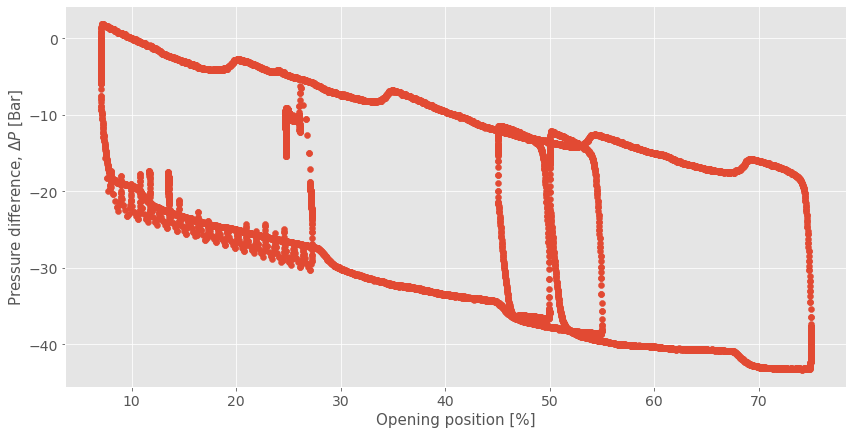

In [65]:
plt.figure(figsize=(14,7))
plt.scatter(df_servo_v3['FCA'], df_servo_v3['diff'])
plt.xlabel('Opening Servomotor position [%]', fontsize = 15)
plt.ylabel('Pressure difference, $\Delta P$ [Bar]', fontsize = 15)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.savefig('servo_pressurediff_pos.png')

In [4]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn import svm

In [5]:
X_test = df_servo_v3[["FCA", "diff"]].sample(n=1000)
X_train = df_servo_v3[["FCA", "diff"]]
X_train = X_train[~X_train.isin(X_test)]
X_train = X_train.dropna()

X_test = np.array(X_test)
X_train = np.array(X_train)

In [6]:
X_train.shape

(17152, 2)

In [7]:
X_train

array([[  7.054294,  -0.491028],
       [  7.054294,  -0.491028],
       [  7.050945,  -0.591355],
       ...,
       [ 24.688046,  -9.90097 ],
       [ 24.688688, -10.050659],
       [ 24.689703, -10.152893]])

In [89]:
gamma=82e-4
nu=13e-4

clf = svm.OneClassSVM(kernel="rbf", gamma=gamma, nu=nu, tol=.01)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size

# create the grid for background colors
h = 0.02
x_min, x_max = X_train[:, 0].min() - 10, X_train[:, 0].max() + 30
y_min, y_max = X_train[:, 1].min() - 10, X_train[:, 1].max() + 10
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z_ = Z.reshape(xx.shape)




In [92]:
pos1, press1 = 85, -30
pos2, press2 = 25, -20
pos3, press3 = 10, -15
pos4, press4 = 30, -10
pos5, press5 = 40, -22
pos6, press6 = 70, -44.8

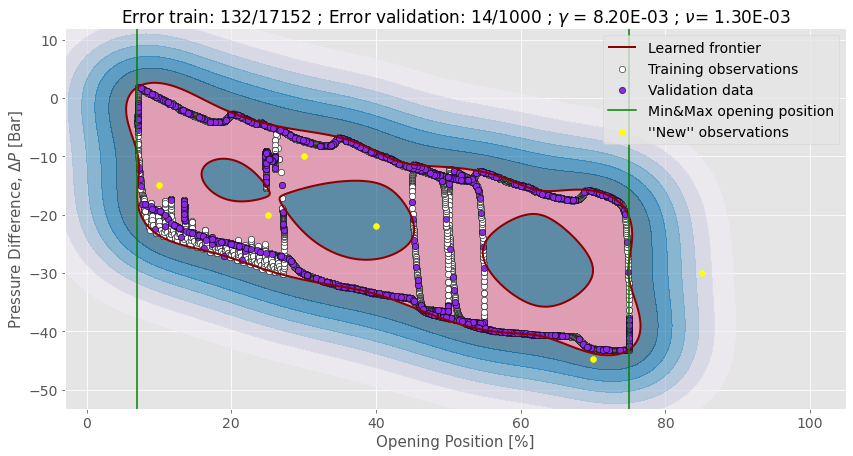

In [93]:
from decimal import Decimal
plt.figure(figsize=(14,7))
plt.contourf(xx, yy, Z_, levels=np.linspace(Z.min()+0.35, 0, 7), cmap=plt.cm.PuBu, alpha=0.6)
a = plt.contour(xx, yy, Z_, levels=[0], linewidths=2, colors="darkred")
plt.contourf(xx, yy, Z_, levels=[0, Z.max()], colors="palevioletred", alpha=0.6)
s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c="white", s=s, edgecolors="k")
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c="blueviolet", s=s, edgecolors="k")
c1 = plt.axvline(x=7, c="green")
c2 = plt.axvline(x=75, c="green")
n = plt.scatter(pos1, press1, c="yellow")
plt.scatter(pos2, press2, c="yellow")
plt.scatter(pos3, press3, c="yellow")
plt.scatter(pos4, press4, c="yellow")
plt.scatter(pos5, press5, c="yellow")
plt.scatter(pos6, press6, c="yellow")
plt.axis("tight")
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
plt.legend(
    [a.collections[0], b1, b2, c1, n],
    [
        "Learned frontier",
        "Training observations",
        "Validation data",
        "Min&Max opening position",
        "''New'' observations"
    ],
    loc="upper right",
    prop=matplotlib.font_manager.FontProperties(size=14),

)
plt.xlabel(
    "Opening Position [%]", fontsize=15
)
plt.title("Error train: %d/17152 ; Error validation: %d/1000 ; $\gamma$ = %.2E ; $\\nu$= %.2E"
    % (n_error_train, n_error_test, Decimal(gamma), Decimal(nu)), fontsize=17)
plt.ylabel('Pressure Difference, $\Delta P$ [Bar]', fontsize=15)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.savefig('OCSVM_servo_v2.png')
plt.show()

In [80]:
def check_new_val(clf, position, pressure):
    import plotly.graph_objects as go
    from decimal import Decimal
    plt.figure(figsize=(14,7))
    plt.contourf(xx, yy, Z_, levels=np.linspace(Z.min()+0.35, 0, 7), 
                 cmap=plt.cm.PuBu, alpha=0.6)
    a = plt.contour(xx, yy, Z_, levels=[0], linewidths=2, colors="darkred")
    plt.contourf(xx, yy, Z_, levels=[0, Z.max()], colors="palevioletred", alpha=0.6)
    s = 40
    b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c="white", s=s, edgecolors="k")
    b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c="blueviolet", s=s, edgecolors="k")
    c1 = plt.axvline(x=7, c="green")
    c2 = plt.axvline(x=75, c="green")
    n = plt.scatter(position, pressure, c="yellow")
    plt.axis("tight")
    plt.xlim((x_min, x_max))
    plt.ylim((y_min, y_max))
    plt.legend(
        [a.collections[0], b1, b2, c1, n],
        [
            "Learned frontier",
            "Training observations",
            "Validation data",
            "Min&Max opening position",
            "''New'' observations"
        ],
        loc="upper right",
        prop=matplotlib.font_manager.FontProperties(size=14),
    )
    plt.xlabel(
        "Opening Position [%]", fontsize=15
    )
    plt.title("Error train: %d/17152 ; Error validation: %d/1000 ; $\gamma$ = %.2E ; $\\nu$= %.2E"
        % (n_error_train, n_error_test, Decimal(gamma), Decimal(nu)), fontsize=17)
    plt.ylabel('Pressure Difference, $\Delta P$ [Bar]', fontsize=15)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.show()
    plt.savefig('OCSVM_newval1.png')
    new_val = clf.decision_function(np.c_[position, pressure])*100
    if position < 7:
        print('Error: Possible oil leakage in the servo')
        fig = go.Figure(go.Indicator(
        mode = "gauge+delta",
        domain = {'x': [0.05, 1], 'y': [0, 1]},
        delta = {'reference': 0, 'position': "top"},
        title = {'text':"<b>Error</b><br><span style='color: gray; font-size:0.8em'>Value outside</span></b><br><span style='color: gray; font-size:0.8em'>of physical</span></b><br><span style='color: gray; font-size:0.8em'>limits</span>", 'font': {"size": 14}},
        gauge = {
            'shape': "bullet",
            'axis': {'range': [-15, 7]},
            'bgcolor': "white",
            'steps': [
                {'range': [-15, 7], 'color': "crimson"}
                ],
            'bar': {'color': "crimson"}}))
        fig.update_layout(height = 250, width = 750)
        fig.show()
    elif position > 75:
        print('Error: Possible oil leakage in the servo')
        fig = go.Figure(go.Indicator(
        mode = "gauge+delta",
        domain = {'x': [0.05, 1], 'y': [0, 1]},
        delta = {'reference': 0, 'position': "top"},
        title = {'text':"<b>Error</b><br><span style='color: gray; font-size:0.8em'>Value outside</span></b><br><span style='color: gray; font-size:0.8em'>of physical</span></b><br><span style='color: gray; font-size:0.8em'>limits</span>", 'font': {"size": 14}},
        gauge = {
            'shape': "bullet",
            'axis': {'range': [-15, 7]},
            'bgcolor': "white",
            'steps': [
                {'range': [-15, 7], 'color': "crimson"}
                ],
            'bar': {'color': "crimson"}}))
        fig.update_layout(height = 250, width = 750)
        fig.show()
    else:
        fig = go.Figure(go.Indicator(
            mode = "number+gauge+delta", value = new_val[0],
            domain = {'x': [0.05, 1], 'y': [0, 1]},
            delta = {'reference': 0, 'position': "top"},
            title = {'text':"<b>Outlier</b><br><span style='color: gray; font-size:0.8em'>position</span></b><br><span style='color: gray; font-size:0.8em'>from</span></b><br><span style='color: gray; font-size:0.8em'>boundary</span>", 'font': {"size": 14}},
            gauge = {
                'shape': "bullet",
                'axis': {'range': [-15, 7]},
                'threshold': {
                    'line': {'color': "red", 'width': 2},
                    'thickness': 0.75, 'value': 0},
                'bgcolor': "white",
                'steps': [
                    {'range': [-15, 0], 'color': "crimson"},
                    {'range': [-10, 0], 'color': "darksalmon"},
                    {'range': [-7, 0], 'color': "hotpink"},
                    {'range': [-5, 0], 'color': "greenyellow"},
                    {'range': [-3, 0], 'color': "lightgreen"},
                    {'range': [-1, 0], 'color': "limegreen"},
                    {'range': [0, 7], 'color': "green"}
                    ],
                'bar': {'color': "black"}}))
        fig.update_layout(height = 250, width = 750)
        fig.show()
    return 



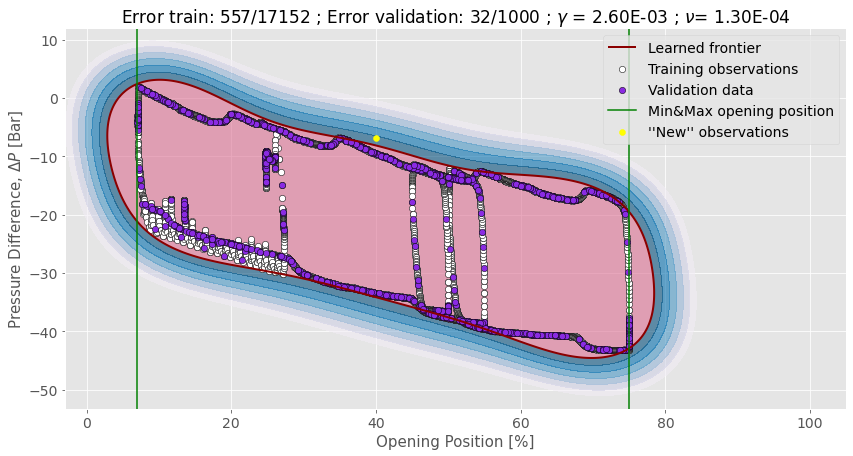

<Figure size 432x288 with 0 Axes>

In [88]:
check_new_val(clf, 40, -6.82)